# II. Use SpatialData with your data: SpatialElements and tables

In the previous notebook we saw how to load and save `SpatialData` objects from Zarr, how to construct them from scratch (assuming that the `SpatialElement` and tables are available) and maniupulate them. 

We will show how to create the `SpatialElement` and tables from scratch. We will see this for images, labels, points, shapes (circles, polygons/multipolygons) and tables.

This notebook is technically detailed; if you first prefer a more practical introduction we suggest to skip the text and just read the commented code. Also, if you need some code to get started you can look at the source code for the readers implemented in [spatialdata-io](https://github.com/scverse/spatialdata-io/tree/main/src/spatialdata_io/readers).

## Data models: validation and parsing

In order to represent `SpatialElement`s and annotation tables, we decided not to introduce new Python classes. Instead, we opted for representing the data using existing classes that are already widely developed and used. Still, we sometimes needed extra structure for those objects. 

To accomplish this, for each type of element (e.g. images) that we support, we provide two functions: a validation function and a parser.

- The validation function determines if the element adheres to the extra structure that we need. Practically, when a `SpatialData` object is constructed, or when a `SpatialElement` or a annotation table is added to an existing `SpatialData` object, the object will be *validated*. If the validation is not met, the user will receive an error message with instructions on how to fix this.
- The parser function takes input data in various formats, converts them to the standard representation for the element and returns an object that is always guaranteed to be valid.

Before diving into the details, let's show a simple example of how to parse and validate a 2D image.

In [1]:
from scipy.datasets import face

# raw data
image = face()
print(type(image))
image.shape

<class 'numpy.ndarray'>


(768, 1024, 3)

In [2]:
import pytest
from spatialdata.models import Image2DModel

# numpy arrays do not pass validation
with pytest.raises(ValueError, match="Unsupported data type: <class 'numpy.ndarray'>."):
    Image2DModel().validate(image)

# let's parse the data
parsed_image = Image2DModel.parse(image, dims=("y", "x", "c"))

# now passes validation (=can be placed inside a SpatialData object)
Image2DModel().validate(parsed_image)

# parsed_image is a regular spatial_image.SpatialImage object (discussed later), and as such it can be used outside
# the SpatialData library (e.g. with the libraries dask-image, xarray-spatial, ...)
parsed_image

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


<xarray.SpatialImage 'image' (c: 3, y: 768, x: 1024)>
dask.array<transpose, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
Attributes:
    transform:  {'global': Identity }

Before delving into the details of each specific element type, let's first see some common characteristic of data models.

- **The correct syntax for single-dispatch**. Most of the parsers and some of the validators are implemented using the single-dispatch Python construct, to automatically calls an appropriate secondary function based on the type of the first argument. As such, the first argument must be unnamed. In other words, calling `Image2DModel.parse(data=image)` is incorrect, while `Image2DModel.parse(image)` is the correct syntax.
- **Passing coordinate transformations**. All the parsers, except for the one for tables, accept the argument `transformations`, to specify a dict of coordinate transformations for the element.

In [3]:
from spatialdata.transformations import Scale, get_transformation, remove_transformation

print(type(image))
parsed_image = Image2DModel.parse(image, dims=("y", "x", "c"))

# the default transformation is an identity
get_transformation(parsed_image)

# let's add custom transformations, first let's remove it
remove_transformation(parsed_image)

# to add new ones let's re-parse parse_image; note that the type of parsed_image is now a SpatialImage, not a numpy.array as before.
# This is not a problem as the single-dispath construct takes care of handling the different data types.
# No need to pass dims now, as the dims are already specified in the parsed_image object
parsed_image = Image2DModel.parse(
    parsed_image,
    transformations={"scale_space": Scale([2.0], axes=("x",)), "another_space": Scale([2.0, 3.0], axes=("y", "x"))},
)
print(type(parsed_image))

# let's check that the axes are correct
from spatialdata.models import get_axes_names

get_axes_names(parsed_image)

<class 'numpy.ndarray'>
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
<class 'spatial_image.SpatialImage'>


('c', 'y', 'x')

## Images

We support 2D and 3D images. The axes (in this order) for 2D images are `('c', 'y', 'x')`. The axes for 3D images are `('c', 'z', 'y', 'x')`. 
We support both single-scale images (aka regular images) and multi-scale images (i.e. the same image downscaled multiple times).

We use the classes `spatial_image.SpatialImage` and `multiscale_spatial_image.MultiscaleSpatialImage` respectively for single-scale and multi-scale images.

The `SpatialImage` class is a subclass of the popular `xarray.DataArray` object. The `MultiscaleSpatialImage` class is a subclass of the `datatree.DataTree`.

> 📝 **Technical note**
> 
> Future versions of `spatialdata` will see a simplification of how images are stored. In details:
> - starting from `spatial_image==1.0.0`, the `spatial_image` library uses `xarray.DataArray` directly instead of a subclass;
> - similarlry, from `multiscale_spatial_image==1.0.0` the `multiscale_spatial_image` library uses the `datatree.DataTree` instead of a subclass;
> - the `datatree.DataTree` class is currently being moved to the `xarray` package, in the future it will be accessible as `xarray.DataTree`, thus without the need of the `datatree` package.

Since the above objects are `xarray` objects, they inherit the benefits of `xarray`. In particular:
- they contain coordinates;
- they can represent the data in chunks;
- they support storing lazy-loaded data with Dask.

> 📝 **Technical note**
> 
> Currently, the `xarray` coordinates are not transformed by coordinate transformations. This is being tracked here https://github.com/scverse/spatialdata/issues/308 and will be addressed in a future release.

The examples below cover the main use cases; please refer to the documentation for all the details.

In [4]:
# when the input data has not dimensions equal to ('c', 'y', 'x'), we can use the dims argument
# of .parse() to transpose the data

# image is ('y', 'x', 'c')
Image2DModel.parse(image, dims=("y", "x", "c"))

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


<xarray.SpatialImage 'image' (c: 3, y: 768, x: 1024)>
dask.array<transpose, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
Attributes:
    transform:  {'global': Identity }

As we quickly saw before, the parser accepts different data types. Currently supported types are `numpy.array`s, `xarray.DataArray` and `dask.array.core.Array`.

In [5]:
# types supported by the single-dispatch construct of the parser

# numpy array (we saw in examples before)
print(type(image))

# xarray data arrays (we saw it in an example before). Remember that spatial_image.SpatialImage is a subclass of xarray.DataArray
print(type(parsed_image))

# dask ("lazy") arrays
from dask.array import from_array

lazy_array = from_array(image)
print(type(lazy_array))
Image2DModel.parse(lazy_array, dims=("y", "x", "c"))

<class 'numpy.ndarray'>
<class 'spatial_image.SpatialImage'>
<class 'dask.array.core.Array'>
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


<xarray.SpatialImage 'image' (c: 3, y: 768, x: 1024)>
dask.array<transpose, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
Attributes:
    transform:  {'global': Identity }

In [6]:
# we can specify the chunk sizes of the image with the argument `chunks`
# warning: this currently doesn't work because of a bug https://github.com/scverse/spatialdata/issues/406
parsed = Image2DModel.parse(image, dims=("y", "x", "c"), chunks=(1, 100, 100))

# please use this workaround instead
parsed.data = parsed.data.rechunk((1, 100, 100))
parsed

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


<xarray.SpatialImage 'image' (c: 3, y: 768, x: 1024)>
dask.array<rechunk-merge, shape=(3, 768, 1024), dtype=uint8, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
Attributes:
    transform:  {'global': Identity }

In [7]:
# the c coordinates can be set by passing the c_coords argument
parsed = Image2DModel.parse(image, dims=("y", "x", "c"), c_coords=["r", "g", "b"])
display(parsed)

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


<xarray.SpatialImage 'image' (c: 3, y: 768, x: 1024)>
dask.array<transpose, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U1 'r' 'g' 'b'
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
Attributes:
    transform:  {'global': Identity }

In [8]:
# let's access the c coords directly using the xarray syntax
print(parsed.c.values)

['r' 'g' 'b']


In [9]:
# a multiscale image can be derived by passing a list of scale factors (chunking works here)
msi = Image2DModel.parse(image, dims=("y", "x", "c"), chunks=(1, 100, 100), scale_factors=[2, 2])
print(msi)

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:  (c: 3, y: 768, x: 1024)
│       Coordinates:
│         * c        (c) int64 0 1 2
│         * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
│         * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:  (c: 3, y: 384, x: 512)
│       Coordinates:
│         * c        (c) int64 0 1 2
│         * y        (y) float64 1.0 3.0 5.0 7.0 9.0 ... 759.0 761.0 763.0 765.0 767.0
│         * x        (x) float64 1.0 3.0 5.0 7.0 ... 1.019e+03 1.021e+03 1.023e+03
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
└── DataTree('scale2')
        Dime

In [10]:
# note: here scale_factors=[2, 2] gives an object with 3 scales:
# scale0: full resolution
# scale1: scale0 downscaled by 2
# scale2: scale0 downscaled by 4 (i.e. scale1 downscaled by 2)
#
# using for instance scale_factors = [1, 2, 4, 8, 16] is incorrect, as it would lead to
# scale0: full resolution
# scale1: full resolution
# scale2: scale0 downscaled by 2
# scale3: scale0 downscaled by 8
# scale4: scale0 downscaled by 64
# scale5: scale0 downscaled by 1024

# let's list the scales
print(list(msi.keys()))

['scale0', 'scale1', 'scale2']


In [11]:
# let's access scale1. This is a DataTree
print(msi["scale1"])

DataTree('scale1', parent="None")
    Dimensions:  (c: 3, y: 384, x: 512)
    Coordinates:
      * c        (c) int64 0 1 2
      * y        (y) float64 1.0 3.0 5.0 7.0 9.0 ... 759.0 761.0 763.0 765.0 767.0
      * x        (x) float64 1.0 3.0 5.0 7.0 ... 1.019e+03 1.021e+03 1.023e+03
    Data variables:
        image    (c, y, x) uint8 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>


In [12]:
# we are interested in the `image` contained in it
msi["scale1"]["image"]

<xarray.DataArray 'image' (c: 3, y: 384, x: 512)>
dask.array<rechunk-merge, shape=(3, 384, 512), dtype=uint8, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 1.0 3.0 5.0 7.0 9.0 ... 759.0 761.0 763.0 765.0 767.0
  * x        (x) float64 1.0 3.0 5.0 7.0 ... 1.019e+03 1.021e+03 1.023e+03
Attributes:
    transform:  {'global': Sequence \n    Scale (y, x)\n        [2. 2.]\n    ...

### Lazy loading of images

The parser returns a `SpatialImage`/`MultiscaleSpatialImage` object that internally relies on a lazy representation using Dask. You can use this to construct lazy-loaded and lazy-computable objects. You can also use chunked data + lazy computations to specify and then run distributed computations on the object.

To load the data in memory, you can use `.compute()`.

In [13]:
# the parsed data is represented lazily with Dask
print(parsed.data)

dask.array<transpose, shape=(3, 768, 1024), dtype=uint8, chunksize=(3, 768, 1024), chunktype=numpy.ndarray>


In [14]:
# you can compute the data (it will not persist in-memory)
print(parsed.data.compute())

[[[121 138 153 ... 119 131 139]
  [ 89 110 130 ... 118 134 146]
  [ 73  94 115 ... 117 133 144]
  ...
  [ 87  94 107 ... 120 119 119]
  [ 85  95 112 ... 121 120 120]
  [ 85  97 111 ... 120 119 118]]

 [[112 129 144 ... 126 136 144]
  [ 82 103 122 ... 125 141 153]
  [ 66  87 108 ... 126 142 153]
  ...
  [106 110 124 ... 158 157 158]
  [101 111 127 ... 157 156 156]
  [101 113 126 ... 156 155 154]]

 [[131 148 165 ...  74  82  90]
  [100 121 143 ...  71  87  99]
  [ 84 105 126 ...  71  87  98]
  ...
  [ 76  81  92 ...  97  96  95]
  [ 72  82  96 ...  96  94  94]
  [ 74  84  97 ...  95  93  92]]]


## Labels

The data types for labels are identical as the ones used for images. Most of the considerations and code examples above are valid, with the following distincions:
- labels don't have the `c` channel
    - therefore their valid axes are `('y', 'x')` for 2D labels and `('z', 'y', 'x')` for 3D labels;
    - therefore they don't accept the `c_coords` kwargs argument in the parser.
- the `dtype` for labels needs to be an integer.

In [15]:
import numpy as np

# the models for labels
from spatialdata.models import Labels2DModel, Labels3DModel

# let's create some 3D data with two classes: 0 (background) and 1
labels_data = np.zeros((5, 10, 15))
labels_data[:2, :, :] = 1

labels = Labels3DModel.parse(labels_data)
labels

INFO     no axes information specified in the object, setting `dims` to: ('z', 'y', 'x')                           


<xarray.SpatialImage 'image' (z: 5, y: 10, x: 15)>
dask.array<array, shape=(5, 10, 15), dtype=float64, chunksize=(5, 10, 15), chunktype=numpy.ndarray>
Coordinates:
  * z        (z) float64 0.5 1.5 2.5 3.5 4.5
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 10.5 11.5 12.5 13.5 14.5
Attributes:
    transform:  {'global': Identity }

## Points

Points are represented as a dataframe object of type `dask.dataframe.core.DataFrame`, which is the Dask version (="lazy") of a regular `pandas.DataFrame`.

Points can be 2D or 3D, and this is determined by the availability, respectively, of the `x`, `y` or of the `x`, `y`, `z` columns. These coordinates columns must be of numerical type.

Points can have any additional other column, for instance storing a gene id information for each point location.

In [16]:
from spatialdata.models import PointsModel

coords = np.array([[1, 1], [2, 3], [4, 5]])
points = PointsModel.parse(coords)

# the type of the parsed points is a "lazy" Dask dataframe
print(type(points))

<class 'dask.dataframe.core.DataFrame'>


In [17]:
points

,x,y
npartitions=1,,
0,int64,int64
2,...,...


In [18]:
# we can compute its values
points.compute()

,x,y
0,1,1
1,2,3
2,4,5


The single-dispatch mechanism for `.parse()` allows to construct points from numpy arrays, from pandas dataframes and from Dask dataframes. Let's see examples for this and also how to specify additional columns beyond `x`, `y`, `z`.

In [19]:
# let's define an annotation dataframe
import pandas as pd

annotation = pd.DataFrame({"gene_id": ["gene_a", "gene_a", "gene_b"]})
annotation["gene_id"] = annotation["gene_id"].astype("category")

In [20]:
# creating the points object from a numpy array + annotation dataframe
parsed_points = PointsModel.parse(coords, annotation=annotation)
print(parsed_points.compute())
print(get_axes_names(parsed_points))

   x  y gene_id
0  1  1  gene_a
1  2  3  gene_a
2  4  5  gene_b
('x', 'y')


In [21]:
# let's add coordinates to the annotations; let's make a copy so we don't modify the previous object (which is passed by reference and not by copy)
annotation = annotation.copy()
annotation["x"] = coords[:, 0]
annotation["y"] = coords[:, 1]

# creating the points object from a pandas dataframe
parsed_points = PointsModel.parse(annotation)
parsed_points.compute()

,x,y,gene_id
0,1,1,gene_a
1,2,3,gene_a
2,4,5,gene_b


In [22]:
# let's now use custom column names for the coordinates columns
annotation = annotation.copy()
annotation.columns = ("gene_id", "my_x", "my_y")
annotation

,gene_id,my_x,my_y
0,gene_a,1,1
1,gene_a,2,3
2,gene_b,4,5


In [23]:
# in case of x and y columns missing, we need to specify the mapping of coordinates
parsed_points = PointsModel.parse(annotation, coordinates={"x": "my_x", "y": "my_y"})
parsed_points.compute()

,x,y,gene_id
0,1,1,gene_a
1,2,3,gene_a
2,4,5,gene_b


In [24]:
# finally, the parser also accepts lazy objects as input
print(type(parsed_points))

<class 'dask.dataframe.core.DataFrame'>


In [25]:
parsed_points = PointsModel.parse(parsed_points)
parsed_points.compute()

,x,y,gene_id
0,1,1,gene_a
1,2,3,gene_a
2,4,5,gene_b


## Shapes

We represent collections vector geometry objects, which we denote with *shapes*, using the `GeoDataFrame` class from `geopandas`.

The `geopandas` library builds on established geospatial infrastructure such as GDAL and GEOS and defines a convenient extension to `pandas.DataFrame` objects which account for spatial information.

In a nutshell, a `GeoDataFrame` object is a `pandas.DataFrame` object which contains an additional column specifying, for each row, a geometry object. The geometry object is specified using `shapely` classes.

In spatialdata, a shape model is a `GeoDataFrame` object with a column called `geometry` specifying the geometry information.

We support the representation of colletions of polygons/multipolygons and collections of circles. Currently mixing these two categories in a single object is not supported.

In details:
- we represent polygon/multipolygons with a `GeoDataFrame` object for which the `geometry` column contains `shapely.Polygon` and/or `shapely.MultiPolygon` objects;
- we represent circles with a `GeoDataFrame` object for which the `geometry` column contains `shapely.Point` objects; the dataframe must have an additional column called `radius`.

### Circles

In [26]:
from spatialdata.models import ShapesModel

# let's create a collection of circles
coords = np.array([[1, 1], [2, 3], [4, 5]])
radii = np.array([1, 2, 3])

# valid geometry values are inherited from geopandas:
# 0: points
# 3: polygons
# 6: multipolygons
ShapesModel.parse(coords, geometry=0, radius=radii)

,geometry,radius
0,POINT (1.00000 1.00000),1
1,POINT (2.00000 3.00000),2
2,POINT (4.00000 5.00000),3


In [27]:
# we can also create a GeoPandas object separately and then parse it
from geopandas import GeoDataFrame
from shapely import Point

centers = [Point(1, 1), Point(2, 3), Point(4, 5)]
gdf = GeoDataFrame({"geometry": centers, "radius": radii})
circles = ShapesModel.parse(gdf)
circles

,geometry,radius
0,POINT (1.00000 1.00000),1
1,POINT (2.00000 3.00000),2
2,POINT (4.00000 5.00000),3


### Polygons/multipolygons

In [28]:
# let's parse a polygons/multipolygons shapes object from a geopandas object with 3 rows: two polygons and one multipolygon
import geopandas as gpd
from shapely import MultiPolygon, Polygon

# let's create the first two polygons
polygon1 = Polygon([(-10, -10), (-10, 10), (10, 10), (10, -10)])
polygon2 = Polygon([(20, 20), (25, 30), (30, 20)])

# let's createa a MultiPolygon consisting of two smaller polygons
small_polygon1 = Polygon([(40, 40), (45, 45), (50, 40)])
small_polygon2 = Polygon([(60, 40), (65, 45), (70, 40)])
multi_polygon = MultiPolygon([small_polygon1, small_polygon2])

# create the GeoDataFrame
gdf = gpd.GeoDataFrame({"geometry": [polygon1, polygon2, multi_polygon]})

# parse it
gdf = ShapesModel.parse(gdf)

There is also a second way to construct a shapes object, from the ragged array representation of the geopandas object that we use internally. This is technical and described in the documentation but we do not recommened its use, so we will omit it here.

We can visualize the shapes object with the `spatialdata-plot` library.

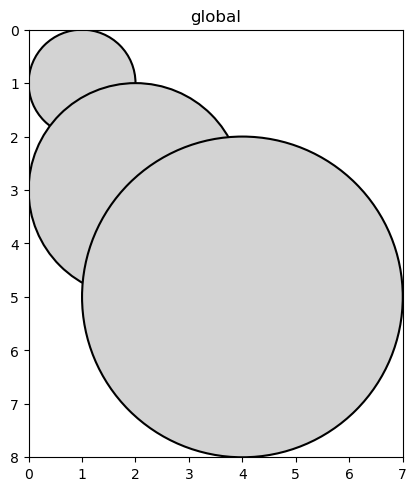

In [29]:
import spatialdata_plot
from spatialdata import SpatialData

sdata = SpatialData.init_from_elements({"circles": circles, "polygons": gdf})
sdata.pl.render_shapes("circles", outline_color="k", outline=True).pl.show()

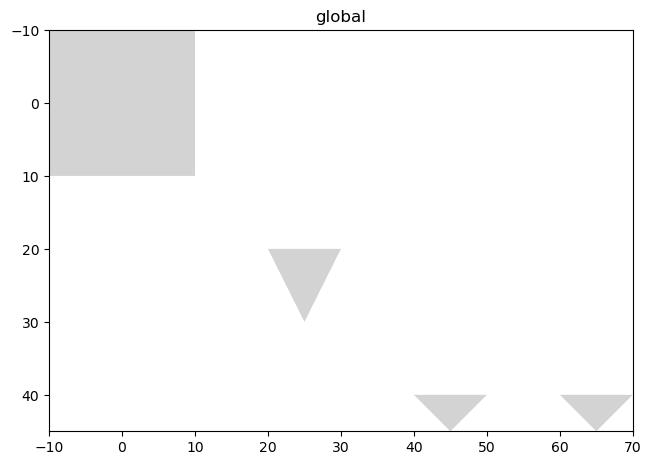

In [30]:
sdata.pl.render_shapes("polygons").pl.show()

Shapes objects can also be parsed directly from a `GeoJSON` file. Let's show this.

In [58]:
from pathlib import Path
from tempfile import TemporaryDirectory

json_file_content = """\
{
    "type": "GeometryCollection",
    "geometries": [
        {
            "type": "Point",
            "coordinates": [10.0, 2.0]
        },
        {
            "type": "Point",
            "coordinates": [5.0, 2.0]
        }
    ]
}
"""

with TemporaryDirectory() as tmpdir:
    f = Path(tmpdir) / "test.json"
    with open(f, "w") as outfile:
        outfile.write(json_file_content)

    shapes = ShapesModel.parse(f, radius=[10, 10])
    print(shapes)

                   geometry  radius
0  POINT (10.00000 2.00000)      10
1   POINT (5.00000 2.00000)      10


## Tables

The final type of elements that we support are annotations tables via `AnnData` objects. Tables are extensively descirbed in our other notebook tutorial "Working with annotations in SpatialData", so here we add some code examples.

In [31]:
from anndata import AnnData
from numpy.random import default_rng
from spatialdata.models import TableModel

RNG = default_rng(seed=0)

# feature matrix
nrows, ncols = 3, 10
feature_matrix = RNG.random((nrows, ncols))

# feature matrix names
var_names = [f"feature{i}" for i in range(ncols)]

# let's use the table to annotate the latest shapes element (polygons/multipolygons)
obs_indices = sdata["polygons"].index

# let's link the table and the shapes element via metadata (this is extensively described in the "Working with annotations in SpatialData" tutorial
obs = pd.DataFrame()
obs["instance_id"] = obs_indices
obs["region"] = "polygons"
obs["region"].astype("category")
obs["extra_feature"] = [1, 2, 3]

# let's construct the AnnData object
table = AnnData(X=feature_matrix, var=pd.DataFrame(index=var_names), obs=obs)

# let's parse it
table = TableModel.parse(table, region="polygons", region_key="region", instance_key="instance_id")

# let's add the table to the SpatialData object
sdata["table"] = table

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_92258/2302229661.py:28: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region="polygons", region_key="region", instance_key="instance_id")


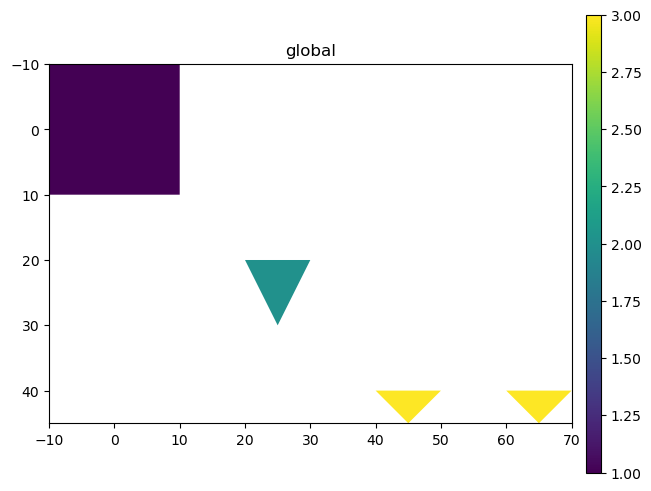

In [32]:
# let's plot some annotations to show the effect of the table annotation

sdata.pl.render_shapes("polygons", color="extra_feature").pl.show()

## Final technical considerations

We conclude with a more technical discussion. We are in the process of incorporating user feedback and simplify the user experience around our data model. We expect therefore these technical considerations to become relaxed over time. And of course, any feedback is welcome.

### How to find the type of an element
Here is a set of convenience functions and suggestions to easily identify which is the type of an element. 

We define the type alias `SpatialElement` as a union type
```python
SpatialElement = Union[SpatialImage, MultiscaleSpatialImage, GeoDataFrame, DaskDataFrame]
```

therefore any element (=spatial element + table) is of type `SpatialElement | AnnData`.

The above is not enough, it does not distinguish between labels and images, nor between 2D images and 3D images. Also it doesn't allow to distinguish between circles and polygons/multipolygons. To solved this, we can look at the model. Here below is the code.

In [33]:
from spatialdata.models import get_model

element = sdata["polygons"]
model = get_model(element)
print(model)

# 2D vs 3D can investigated as follows
axes = get_axes_names(element)
axes

<class 'spatialdata.models.models.ShapesModel'>


('x', 'y')

In [34]:
# we can therefore combine the two approaches above, for instance in the function shown here below
# note: for the moment we don't have such a function in the framework, but we are considering adding one
from spatialdata.models import Image3DModel, Labels2DModel, SpatialElement


def describe_type(element: SpatialElement | AnnData) -> tuple[str, bool | None, bool]:
    is_3d = "z" in axes
    is_multiscale = None
    if model in [Image2DModel, Image3DModel, Labels2DModel, Labels3DModel]:
        is_multiscale = isinstance(element, MultiscaleSpatialImage)
        type = "image" if model in [Image2DModel, Image3DModel] else "labels"
    elif model == ShapesModel:
        if isinstance(element.geometry.iloc[0], Point):
            type = "circles"
        else:
            # polygons/multipolygons case
            type = "polygons"
    elif model == PointsModel:
        type = "points"
    else:
        type = "table"
    return type, is_multiscale, is_3d


print(describe_type(sdata["polygons"]))

('polygons', None, False)


### lazy vs non-lazy data
Currently images, labels and points are represented as lazy object, and if you want to see their values, or if you want to execute a lazy computation on them, `.compute()` needs to be called. On the other hand tables and shapes are fully load into memory. We want to add the flexibility for the user to choose between lazy and non-lazy representation for each element and easily swtich between them. This is being tracked here: https://github.com/scverse/spatialdata/issues/293.

### 3D for shapes
The library `geopandas` has limited support for `z` coordinates in the sense that they can be stored but every operation is "planar" and it ignores the `z` dimension. This is one of the reason why currently we are separating between points (stored as Dask dataframes) and shapes (stored as `geopandas` dataframes).

Anyway, we could still use `geopandas` for 3D data and manually implement missing 3D cases. In fact, after receiving user feedback we are considering performing the following simplification to the models.

- Drop the separation between points and circles: circles could be just points with a radius.
- Use the library `dask-geopandas` to allow lazy representation for shapes (this is required for points since points datasets are usually much bigger).

Practically, until this is finalized, the user can still convert between Dask dataframe points elements and `GeoDataFrame` representations of them (which do not pass `ShapesModel.validation()`, using the helper functions shown next. 

This conversion can be useful if the user is interested in using the `geopandas` APIs directly.

In [35]:
from spatialdata.models import (
    points_dask_dataframe_to_geopandas,
    points_geopandas_to_dask_dataframe,
)

geopandas_points = points_dask_dataframe_to_geopandas(points)

# this GeoDataFrame would not pass validation because the radius column is missing
with pytest.raises(ValueError, match="Column `radius` not found."):
    ShapesModel.validate(geopandas_points)
geopandas_points

,geometry
0,POINT (1.00000 1.00000)
1,POINT (2.00000 3.00000)
2,POINT (4.00000 5.00000)


In [36]:
points_again = points_geopandas_to_dask_dataframe(geopandas_points)

# this is a valid points element
PointsModel.validate(points_again)

points_again

,x,y
npartitions=1,,
0,float64,float64
2,...,...


Finally, note that shapes should always be 2D. It is possible to construct 3D shapes but the validation will warn you and suggest to remove the third dimension. Let's see this.

In [37]:
# let's create a shapes object (circles) constructed from 3D points
circles_3d = ShapesModel.parse(GeoDataFrame({"geometry": (Point(1, 1, 1), Point(2, 2, 2)), "radius": [2, 2]}))
print(circles_3d)

polygon1 = Polygon([(0, 0, 0), (1, 0, 0), (1, 1, 0)])
polygon2 = Polygon([(0, 0, 2), (1, 0, 2), (1, 1, 2)])

# let's create a shapes object (polygons) constructed from 3D polygons
polygons_3d = ShapesModel.parse(GeoDataFrame({"geometry": [polygon1, polygon2]}))
print(polygons_3d)

# let's create a shapes object (multipolygons) constructed from 3D multipolygons
multipolygons_3d = ShapesModel.parse(GeoDataFrame({"geometry": [MultiPolygon([polygon1, polygon2])]}))
print(multipolygons_3d)

                            geometry  radius
0  POINT Z (1.00000 1.00000 1.00000)       2
1  POINT Z (2.00000 2.00000 2.00000)       2
                                            geometry
0  POLYGON Z ((0.00000 0.00000 0.00000, 1.00000 0...
1  POLYGON Z ((0.00000 0.00000 2.00000, 1.00000 0...
                                            geometry
0  MULTIPOLYGON Z (((0.00000 0.00000 0.00000, 1.0...


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:464: UserWarning: The geometry column of the GeoDataFrame has 3 dimensions, while 2 is expected. Please consider discarding the third dimension as it could led to unexpected behaviors.
  cls.validate(data)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:464: UserWarning: The geometry column of the GeoDataFrame has 3 dimensions, while 2 is expected. Please consider discarding the third dimension as it could led to unexpected behaviors.
  cls.validate(data)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:464: UserWarning: The geometry column of the GeoDataFrame has 3 dimensions, while 2 is expected. Please consider discarding the third dimension as it could led to unexpected behaviors.
  cls.validate(data)


The validation gave warnings and you can see that the output shows `POINT Z`, `POLYGON Z` and `MULTIPOLYGON Z`. Let's see how to drop the `z` dimension.

In [42]:
# geopandas introduced a method called force_2d() to drop the z dimension, unfortunately this feature, as of geopandas == 0.14.3, is still not released.
# The recently release shapely >= 2.0.3 implementes force_2d(), but currently there are installation errors. Therefore let's remove the dimension manually.
# Therefore, we temporarily implemented this feature as a helper function in spatialdata

from spatialdata.models import force_2d

force_2d(circles_3d)
force_2d(polygons_3d)
force_2d(multipolygons_3d)

print(circles_3d)
print(polygons_3d)
print(multipolygons_3d)

                  geometry  radius
0  POINT (1.00000 1.00000)       2
1  POINT (2.00000 2.00000)       2
                                            geometry
0  POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
1  POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
                                            geometry
0  MULTIPOLYGON (((0.00000 0.00000, 1.00000 0.000...


### Relationship between single-scale vs multi-scale
More Advanced topic. Let's now examine the relationship between the `SpatialImage` object and the `MultiscaleSpatialImage` object.

In [39]:
# this is a more technical example
# the image in each scale of a MultiscaleSpatialImage object is actually a xarray.DataTree and not a SpatialImage
print(type(msi["scale1"]["image"]))

# we can fix this easily
from spatial_image import SpatialImage

si = SpatialImage(msi["scale1"]["image"])
print(type(si))

# future vesions of spatialdata will use "spatial_image >= 1.0.0" which uses `DataArray` directly, removing the
# need for the last extra step

<class 'xarray.core.dataarray.DataArray'>
<class 'spatial_image.SpatialImage'>


In [40]:
# let's slice a DataTree
sliced = msi.sel(x=slice(10, 100))
print(sliced)

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:  (c: 3, y: 768, x: 90)
│       Coordinates:
│         * c        (c) int64 0 1 2
│         * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 763.5 764.5 765.5 766.5 767.5
│         * x        (x) float64 10.5 11.5 12.5 13.5 14.5 ... 95.5 96.5 97.5 98.5 99.5
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(1, 100, 90), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:  (c: 3, y: 384, x: 45)
│       Coordinates:
│         * c        (c) int64 0 1 2
│         * y        (y) float64 1.0 3.0 5.0 7.0 9.0 ... 759.0 761.0 763.0 765.0 767.0
│         * x        (x) float64 11.0 13.0 15.0 17.0 19.0 ... 91.0 93.0 95.0 97.0 99.0
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(1, 100, 45), meta=np.ndarray>
└── DataTree('scale2')
        Dimensions:  (c: 3, y: 192, x: 23)
        Coordinates:
          * c        (c) int64 0 1 2
          * y        (y)

In [41]:
# sliced is actually a DataTree, not a MultiscaleSpatialImage
type(sliced)

# we can fix this with a convenience function from spatialdata
from spatialdata._utils import multiscale_spatial_image_from_data_tree

type(multiscale_spatial_image_from_data_tree(sliced))

# future vesions of spatialdata will use "multiscale_spatial_image >= 1.0.0" which uses `DataTree` directly, removing the
# need for the last extra step

multiscale_spatial_image.multiscale_spatial_image.MultiscaleSpatialImage